# Example use of the Sonic module Linckii.jl

* https://julialang.org
* https://juliadb.org
* https://juliastats.org

In [26]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [31]:
import Dates, JuliaDB, Random, StatsPlots

┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


In [33]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

In [4]:
include("../src/Linckii.jl")
include("../src/LinckiiSecrets.jl")

Main.LinckiiSecrets

Get access token,

In [5]:
access = Linckii.get_access(LinckiiSecrets.keab)

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

GET "https://canary.noda.se/$site_name/api/v1/node"

In [6]:
@time nodes = Linckii.get_nodes(access)

 32.754293 seconds (32.76 M allocations: 1.989 GiB, 1.94% gc time)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String

GET "https://canary.noda.se/$site_name/api/v1/device"

In [7]:
@time devices = Linckii.get_devices(access)

 17.699284 seconds (16.20 M allocations: 1.098 GiB, 1.77% gc time)


Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13

GET "https://canary.noda.se/$site_name/api/v1/sensor"

In [8]:
@time sensors = Linckii.get_sensors(access)

 33.703840 seconds (31.45 M allocations: 2.126 GiB, 1.93% gc time)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

Save site,

In [9]:
@time Linckii.savesite(access; nodes = nodes, devices = devices, sensors = sensors)

  3.235190 seconds (7.91 M allocations: 402.345 MiB, 4.59% gc time)


Load site,

In [10]:
@time nodes, devices, sensors = Linckii.loadsite(access, :nodes, :devices, :sensors)

  0.095437 seconds (81.16 k allocations: 4.490 MiB, 22.08% gc time)


(nodes = Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String, devices = Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13, sensors = Table with 175 rows, 5 columns:
Columns:
#  colname             type
───────────────────

Select data,

In [22]:
device_ids = (4, )

(4,)

In [11]:
sensor_names = (
    :meter_effect,
    :meter_primreturntemp,
    :meter_primsupplytemp,
    :meter_volumeflow,
)

(:meter_effect, :meter_primreturntemp, :meter_primsupplytemp, :meter_volumeflow)

In [12]:
signals = JuliaDB.reindex(
    JuliaDB.join(
        Linckii.flatten_nodes(JuliaDB.filter(r -> r.device_id in device_ids 4, nodes)),
        JuliaDB.filter(r -> r.sensor_name in sensor_names, sensors);
        lkey=:sensor_id,
        rkey=:sensor_id,
    ),
    (:node_id, :sensor_id),
)

Table with 361 rows, 12 columns:
Columns:
#   colname             type
──────────────────────────────
1   node_id             Int64
2   sensor_id           Int64
3   node_public         Bool
4   node_name           String
5   device_id           Int64
6   node_owner          Bool
7   node_enabled        Bool
8   node_description    String
9   sensor_unit         Any
10  sensor_name         Symbol
11  protocol_id         Int64
12  sensor_description  String

Save data,

In [13]:
dates = Dates.DateTime(2017, 12) : Dates.Month(1) : Dates.DateTime(2019, 12)

2017-12-01T00:00:00:1 month:2019-12-01T00:00:00

In [14]:
rs = JuliaDB.rows(signals)
if false
    rs = [rs[Random.rand(1 : end)]]
end
@time for r in rs
    filepath = "$(Linckii.datapath(access, r.node_id, r.sensor_name)).db"
    if !isfile(filepath)
        try
            Linckii.savedata(access, r.node_id, r.sensor_name, dates...)
            println("$(filepath): Done")
        catch e
            println("$(filepath): $(e)")
        end
    end
end

db/linckii/~keab/data/1/meter_effect.db: Done
db/linckii/~keab/data/1/meter_primreturntemp.db: Done
db/linckii/~keab/data/1/meter_primsupplytemp.db: Done
db/linckii/~keab/data/1/meter_volumeflow.db: Done
db/linckii/~keab/data/16/meter_effect.db: ErrorException("column datetime not found.")
db/linckii/~keab/data/16/meter_primreturntemp.db: ErrorException("column datetime not found.")
db/linckii/~keab/data/16/meter_primsupplytemp.db: ErrorException("column datetime not found.")
db/linckii/~keab/data/16/meter_volumeflow.db: ErrorException("column datetime not found.")
db/linckii/~keab/data/17/meter_effect.db: Done
db/linckii/~keab/data/17/meter_primreturntemp.db: Done
db/linckii/~keab/data/17/meter_primsupplytemp.db: Done
db/linckii/~keab/data/17/meter_volumeflow.db: Done
db/linckii/~keab/data/18/meter_effect.db: Done
db/linckii/~keab/data/18/meter_primreturntemp.db: Done
db/linckii/~keab/data/18/meter_primsupplytemp.db: Done
db/linckii/~keab/data/18/meter_volumeflow.db: Done
db/linckii/~

Load data,

In [18]:
r = JuliaDB.rows(signals)[Random.rand(1 : end)]
(r.node_id, r.sensor_name)

(57, :meter_volumeflow)

In [19]:
data = Linckii.loaddata(access, r.node_id, r.sensor_name)

Table with 96524 rows, 5 columns:
datetime             timezone  node_id  variable           value
─────────────────────────────────────────────────────────────────
2017-12-01T00:02:02  13:00:00  57       :meter_volumeflow  1004.0
2017-12-01T00:12:03  13:00:00  57       :meter_volumeflow  1033.0
2017-12-01T00:22:03  13:00:00  57       :meter_volumeflow  903.0
2017-12-01T00:32:03  13:00:00  57       :meter_volumeflow  903.0
2017-12-01T00:42:02  13:00:00  57       :meter_volumeflow  1026.0
2017-12-01T00:52:02  13:00:00  57       :meter_volumeflow  997.0
2017-12-01T01:02:03  13:00:00  57       :meter_volumeflow  939.0
2017-12-01T01:12:03  13:00:00  57       :meter_volumeflow  892.0
2017-12-01T01:22:03  13:00:00  57       :meter_volumeflow  950.0
2017-12-01T01:32:02  13:00:00  57       :meter_volumeflow  954.0
2017-12-01T01:42:02  13:00:00  57       :meter_volumeflow  864.0
2017-12-01T01:52:03  13:00:00  57       :meter_volumeflow  907.0
⋮
2019-11-30T22:12:03  13:00:00  57       :meter_vol

Simple plot,

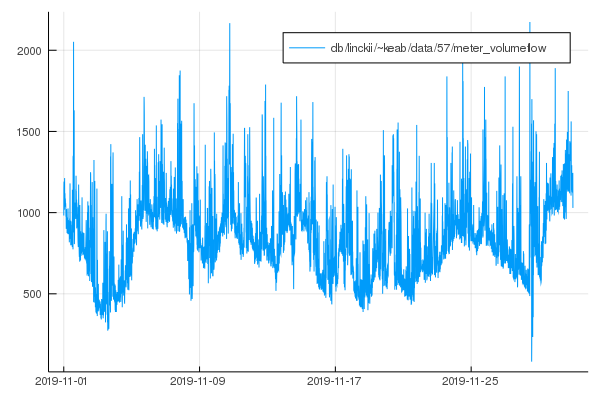

In [39]:
t = JuliaDB.filter(
    r -> r.datetime >= Dates.DateTime(2019, 11) && r.datetime <= Dates.DateTime(2019, 12),
    data,
)
@df t plot(:datetime, :value, label = Linckii.datapath(access, r.node_id, r.sensor_name))